In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import os
import math
import bisect
import tensorflow as tf

sys.path.insert(0, '../../..')

from cde.density_estimator import GPDExtremeValueMixtureDensityNetwork
from cde.density_estimator import MixtureDensityNetwork
from cde.density_estimator import ExtremeValueMixtureDensityNetwork

from cde.data_collector import MatlabDataset, MatlabDatasetH5, get_most_common_unique_states
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill
from cde.evaluation.empirical_eval import evaluate_models_singlestate, empirical_measurer, evaluate_model_allstates, evaluate_models_allstates_plot, obtain_exp_value, evaluate_models_allstates_agg


/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/s

In [2]:
""" Load or Create Project """

# name
PROJECT_NAME = 'project_compare_1k'

# Path
projects_path = 'saves/projects/'
path = projects_path + PROJECT_NAME + '/'
  
# Get the directory name from the specified path
dirname = os.path.dirname(path)

# create the dir
os.makedirs(dirname, exist_ok=True)


In [3]:
""" create training data """

FILE_NAME = 'traindata_gamma.npz'

batch_size = 1000
training_dataset = MatlabDataset('../../data/fulldataset_gamma_400k.mat')
train_data = training_dataset.get_data(batch_size)
ndim_x = len(train_data[0])-1
meta_info = np.array([batch_size,ndim_x])
np.savez(path + FILE_NAME, train_data, meta_info)


dataset loaded from .mat file. Rows: 399997   Columns: 4 


In [3]:
""" load training data """

FILE_NAME = 'traindata_gamma.npz'

npzfile = np.load(path + FILE_NAME)
train_data = npzfile['arr_0']
meta_info = npzfile['arr_1']
batch_size = meta_info[0]
ndim_x = meta_info[1]

print('training data loaded from .npz file. Rows: %d ' % len(train_data), ' Columns: %d ' % len(train_data[0]), 'Batch_size: %d' % batch_size, 'ndim_x: %d' % ndim_x)

training data loaded from .npz file. Rows: 1000   Columns: 4  Batch_size: 1000 ndim_x: 3


In [7]:
""" create models and train them """


FILE_NAME = 'est_models.pkl'

n_epoch = 40000
Y = train_data[:,0]
X = train_data[:,1:]


model_1 = GPDExtremeValueMixtureDensityNetwork("A_EMM1", ndim_x=ndim_x, n_centers=1, ndim_y=1, n_training_epochs=n_epoch, hidden_sizes=(16, 16),verbose_step=math.floor(n_epoch/10), weight_decay=1e-4, learning_rate=1e-4,epsilon=1e-6)
model_1.fit(X, Y)

n_epoch = 5000
model_2 = MixtureDensityNetwork("B_GMM_1", ndim_x=ndim_x, n_centers=1, ndim_y=1,n_training_epochs=n_epoch,hidden_sizes=(16, 16),weight_decay=1e-4)
model_2.fit(X, Y)

n_epoch = 5000
model_3 = MixtureDensityNetwork("B_GMM_2", ndim_x=ndim_x, n_centers=5, ndim_y=1,n_training_epochs=n_epoch,hidden_sizes=(32, 32),weight_decay=1e-4)
model_3.fit(X, Y)

n_epoch = 5000
model_4 = MixtureDensityNetwork("B_GMM_3", ndim_x=ndim_x, n_centers=10, ndim_y=1,n_training_epochs=n_epoch,hidden_sizes=(32, 32),weight_decay=1e-4)
model_4.fit(X, Y)


models = [model_1,model_2,model_3,model_4]
with open(path + FILE_NAME, 'wb') as output:
    pickle.dump(models, output, pickle.HIGHEST_PROTOCOL)


5000/5000 [100%] ██████████████████████████████ Elapsed: 36s | loss: 1022.339
mean log-loss train: 1.0223
5000/5000 [100%] ██████████████████████████████ Elapsed: 66s | loss: 757.229
mean log-loss train: 0.7572
5000/5000 [100%] ██████████████████████████████ Elapsed: 92s | loss: 666.362
mean log-loss train: 0.6664


In [4]:
""" load trained models """

FILE_NAME = 'est_models.pkl'

with open(path+FILE_NAME, 'rb') as input:
    sess = tf.Session()
    with sess:
        d_models = pickle.load(input)

emm_model = d_models[0]
emm_model._setup_inference_and_initialize()

gmm_model = d_models[1]
gmm_model._setup_inference_and_initialize()

pmm_model = d_models[2]
pmm_model._setup_inference_and_initialize()

n_epoch = emm_model.n_training_epochs

print(d_models)
print('n_epoch: %d'%n_epoch)


[GPDExtremeValueMixtureDensityNetwork(epsilon=1e-06, hidden_sizes=(32, 32),
                                     learning_rate=0.0001,
                                     n_training_epochs=10000, name='EMM_GPD',
                                     ndim_x=3, ndim_y=1, verbose_step=1000,
                                     x_noise_std=0.0, y_noise_std=0.0), MixtureDensityNetwork(hidden_sizes=(32, 32), n_training_epochs=10000,
                      name='GMM', ndim_x=3, ndim_y=1, x_noise_std=0.0,
                      y_noise_std=0.0), ExtremeValueMixtureDensityNetwork(hidden_sizes=(32, 32), learning_rate=0.001,
                                  n_training_epochs=10000, name='EMM_PL',
                                  ndim_x=3, ndim_y=1, verbose_step=1000,
                                  x_noise_std=0.0, y_noise_std=0.0)]
n_epoch: 10000


In [9]:
""" import the test dataset into Numpy array """

FILE_NAME = 'testdata_gamma.npz'

file_addrs = ['../../data/package/records_A1.mat','../../data/package/records_A2.mat',
                '../../data/package/records_A3.mat','../../data/package/records_A4.mat',
                '../../data/package/records_B1.mat','../../data/package/records_B2.mat',
                '../../data/package/records_B3.mat','../../data/package/records_B4.mat']

content_keys = ['records_A1','records_A2','records_A3','records_A4',
                    'records_B1','records_B2','records_B3','records_B4']

select_cols = [0,1,5,9]
# define the test packet stream

start_time = time.time()
# 130 seconds each, 15 minutes total
for i in range(len(file_addrs)):
    cond_matds = MatlabDatasetH5(file_address=file_addrs[i],content_key=content_keys[i],select_cols=select_cols)
    if i is 0:
        test_data = cond_matds.dataset
    else:
        test_data = np.append(test_data,cond_matds.dataset,axis=0)

ndim_x_test = len(test_data[0])-1

meta_info = np.array([ndim_x_test])
np.savez(projects_path + FILE_NAME, test_data, meta_info)

print('test data loaded from .mat files. Rows: %d ' % len(test_data), ' Columns: %d ' % len(test_data[0]), 'ndim_x: %d' % ndim_x_test)

 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
1664.6
test data loaded from .mat files. Rows: 703997456   Columns: 4  ndim_x: 3


In [10]:
""" load the test dataset """

FILE_NAME = 'testdata_gamma.npz'

npzfile = np.load(projects_path + FILE_NAME)
test_data = npzfile['arr_0']
meta_info = npzfile['arr_1']
ndim_x_test = meta_info[0]

print('test data loaded from .npz file. Rows: %d ' % len(test_data), ' Columns: %d ' % len(test_data[0]), 'ndim_x: %d' % ndim_x_test)


test data loaded from .npz file. Rows: 703997456   Columns: 4  ndim_x: 3


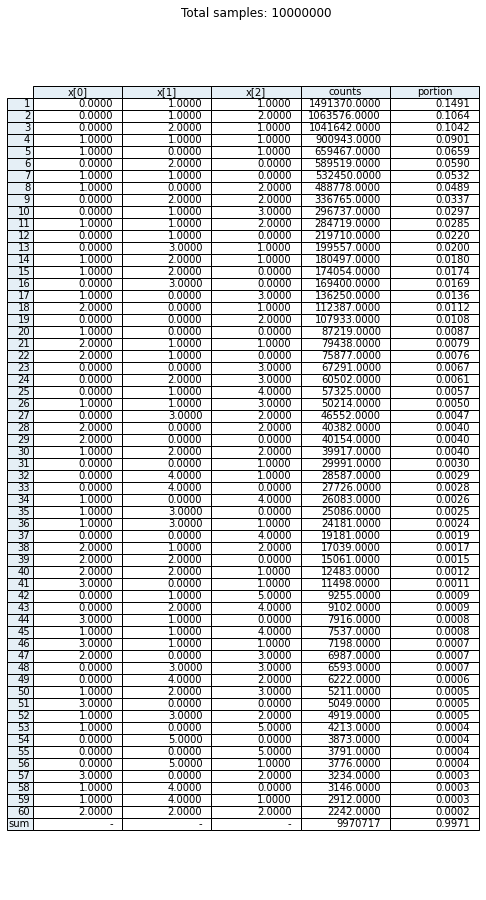

In [78]:
unique_states,_,_ = get_most_common_unique_states(test_data[:10000000,:],ndim_x=3,N=60,plot=True)

 Dataset H5 loaded from .mat file. Rows: 3543194   Columns: 4 


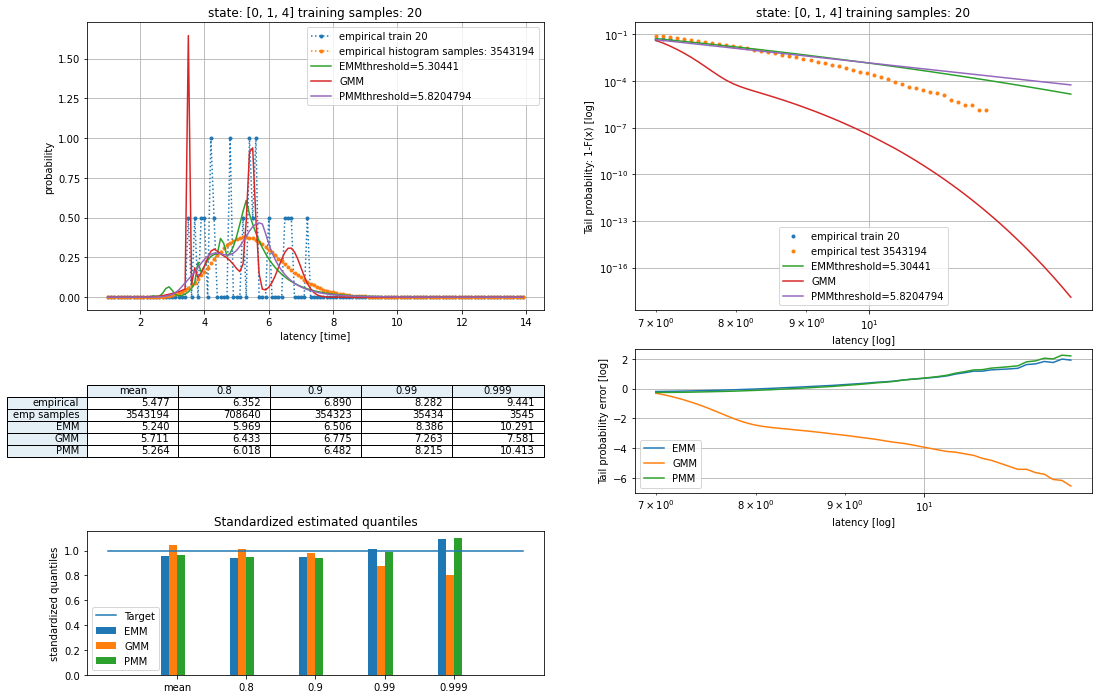

 Dataset H5 loaded from .mat file. Rows: 12051   Columns: 4 


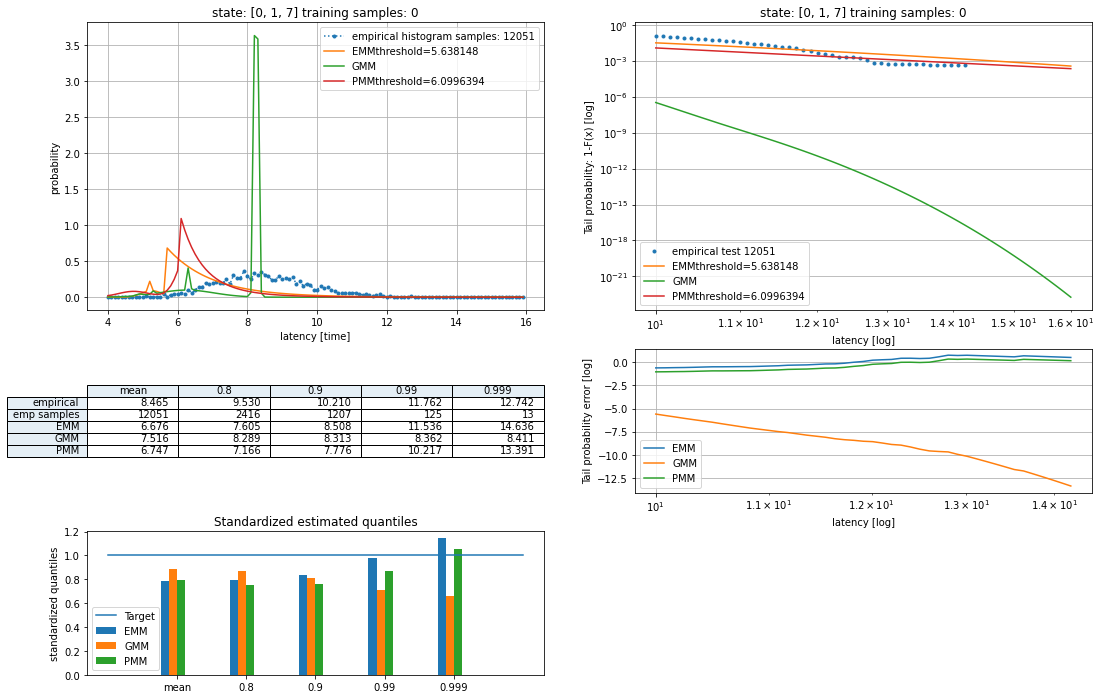

In [40]:
""" Benchmark models on single states """

import warnings
warnings.filterwarnings('ignore')

evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,1,4],file_addr='../../data/cond_records_[0_1_4]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-2,1-1e-3])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,1,7],file_addr='../../data/cond_records_[0_1_7]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-2,1-1e-3])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[1,4,0],test_dataset=test_data,quantiles=[1-1e-1,1-1e-2,1-1e-3,1-1e-4,1-1e-5])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,5,1],test_dataset=test_data,quantiles=[1-1e-1,1-1e-2,1-1e-3,1-1e-4,1-1e-5])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[3,0,2],test_dataset=test_data,quantiles=[1-1e-1,1-1e-2,1-1e-3,1-1e-4,1-1e-5])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,1,1],file_addr='../../data/cond_records_[0_1_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,1,2],file_addr='../../data/cond_records_[0_1_2]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[0,2,1],file_addr='../../data/cond_records_[0_2_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
evaluate_models_singlestate(models=[emm_model,gmm_model,pmm_model],model_names=["EMM","GMM","PMM"],train_data=train_data,cond_state=[1,1,1],file_addr='../../data/cond_records_[1_1_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 
../../../cde/BaseConditionalDensity.py:277: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, y, init_bound)[0]
../../../cde/BaseConditionalDensity.py:277: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, y, init_bound)[0]
../../../cde/BaseConditionalDensity.py:267: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields

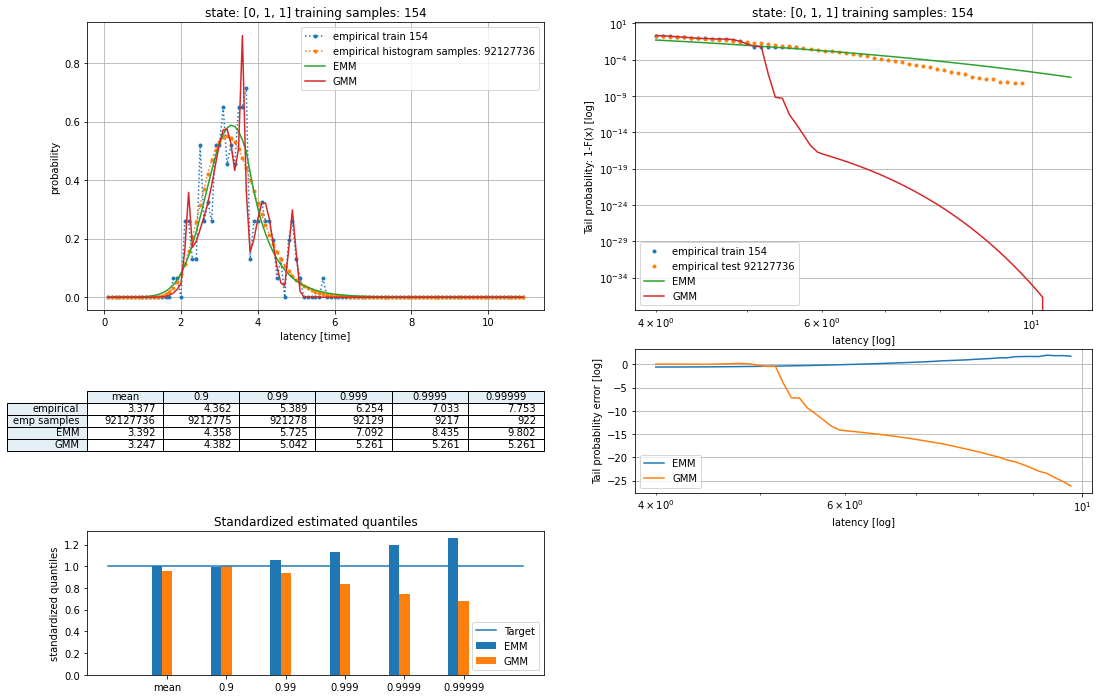

In [8]:
evaluate_models_singlestate(models=[emm_model,gmm_model],model_names=["EMM","GMM"],train_data=train_data,cond_state=[0,1,1],file_addr='../../data/cond_records_[0_1_1]_92M.mat',quantiles=[0.9,0.99,0.999,0.9999,0.99999])

In [ ]:
# instead of P(x) -> training samples [log scale]
# legend shapes -> no color
# deviation from ground truth
# y axis -> [log]
# try GPD at the tail
# Related work
# Aggregate error for each quantile
# Underestimation figure -> its a problem
# write-up
# 4k, 40k, 400k, and other service processes

In [79]:
""" Benchamrk the models upon all the states """
""" Requirements: models, emp_model, test_data, ndim_x_test, and unique_states """

FILE_NAME = 'benchmark_allstate.npz'

quantiles = [0.9, 0.99, 0.999, 0.9999, 0.99999] #quantiles = [0.9, 0.99, 0.999, 0.9999, 0.99999]
xsize = ndim_x_test
N=60 # N=60
emp_model = empirical_measurer(dataset=test_data,xsize=xsize,quantiles=quantiles)

# warning - takes 1 hour
# the first model treats with .tail_inverse, the rest with find_perc
# N=60, len(quantiles)=5, 1.5 hour

eval_results = np.empty((0,N,xsize+(len(quantiles))+1))
# EMM1
emm1_results = evaluate_model_allstates(emp_model=emp_model,model=model_1,train_data=train_data,unique_states=unique_states,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[emm1_results],axis=0)

# EMM2
emm2_results = evaluate_model_allstates(emp_model=emp_model,model=model_2,train_data=train_data,unique_states=unique_states,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[emm2_results],axis=0)

# EMM3
emm3_results = evaluate_model_allstates(emp_model=emp_model,model=model_3,train_data=train_data,unique_states=unique_states,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[emm3_results],axis=0)

# EMM4
emm4_results = evaluate_model_allstates(emp_model=emp_model,model=model_4,train_data=train_data,unique_states=unique_states,N=N,quantiles=quantiles,xsize=xsize,root_find=False)
eval_results = np.append(eval_results,[emm4_results],axis=0)


# save the results into a file
meta_info = np.array([xsize,N])
quantiles_info = np.array(quantiles)
np.savez(path + FILE_NAME, meta_info, quantiles_info, emp_model.database, emm1_results, emm2_results, emm3_results, emm4_results)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [52]:
""" Load the benchamrk results of the models upon all the states """

FILE_NAME = 'benchmark_allstate.npz'

npzfile = np.load(path + FILE_NAME)
meta_info = npzfile['arr_0']
quantiles = npzfile['arr_1']
xsize = meta_info[0]
N = meta_info[1]

#emp_model = empirical_measurer(dataset=test_data,xsize=xsize,quantiles=quantiles)
#emp_model.database = npzfile['arr_2']

#eval_results_1 = np.empty((0,N,xsize+(len(quantiles))+1))
emm1_results_p = npzfile['arr_3']
#eval_results_1 = np.append(eval_results_1,[emm1_results],axis=0)
emm2_results_p = npzfile['arr_4']
#eval_results_1 = np.append(eval_results_1,[gmm_results],axis=0)
emm3_results_p = npzfile['arr_5']
emm4_results_p = npzfile['arr_6']
#eval_results_1 = np.append(eval_results_1,[pmm_results],axis=0)

print('benchmark allstate loaded from .npz file. Models: %d ' % len(eval_results), ' n_states(N): %d ' % len(eval_results[0]), 'xsize: %d' % xsize)

benchmark allstate loaded from .npz file. Models: 4   n_states(N): 10  xsize: 3


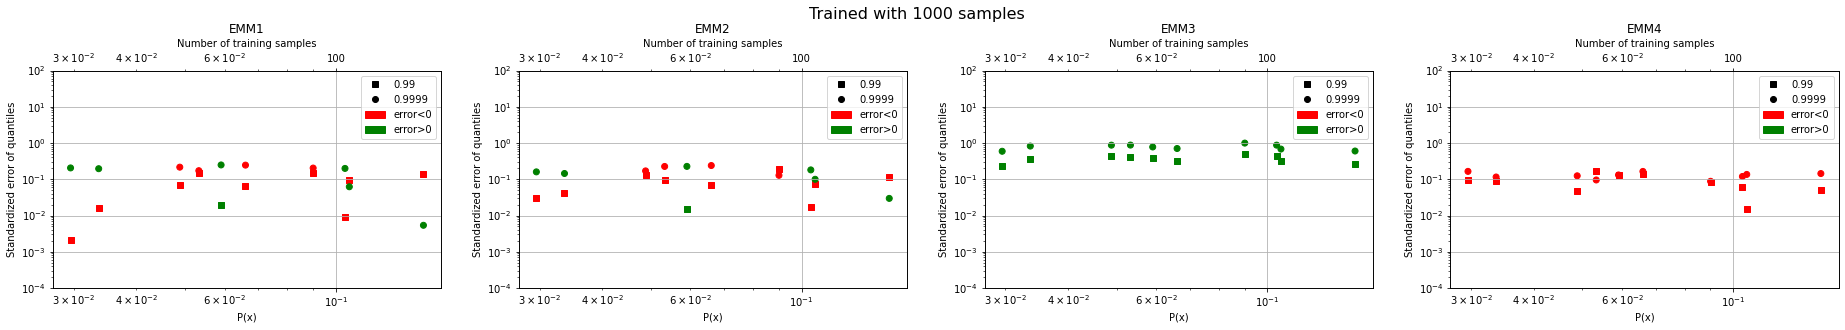

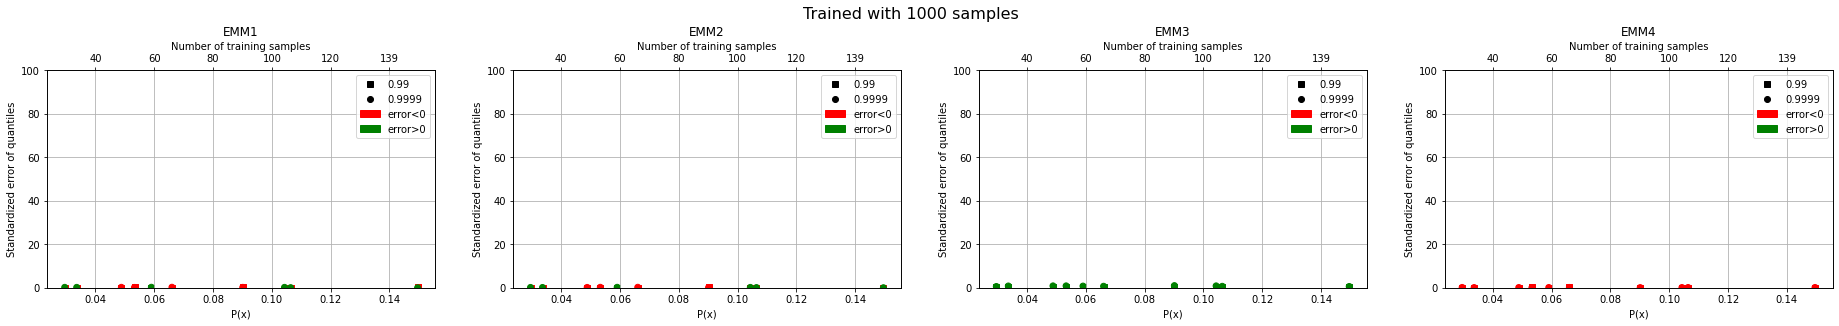

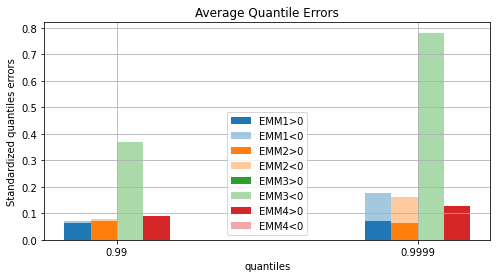

In [29]:
evaluate_models_allstates_plot(cma_results=eval_results,train_len=len(train_data),model_names=['EMM1','EMM2','EMM3','EMM4'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=True,ylim_ll=[1e-4,1e2])
evaluate_models_allstates_plot(cma_results=eval_results,train_len=len(train_data),model_names=['EMM1','EMM2','EMM3','EMM4'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=False,ylim=[0,100])
evaluate_models_allstates_agg(cma_results=eval_results,train_len=len(train_data),n_epoch=n_epoch,xsize=xsize,quantiles=quantiles,model_names=['EMM1','EMM2','EMM3','EMM4'])

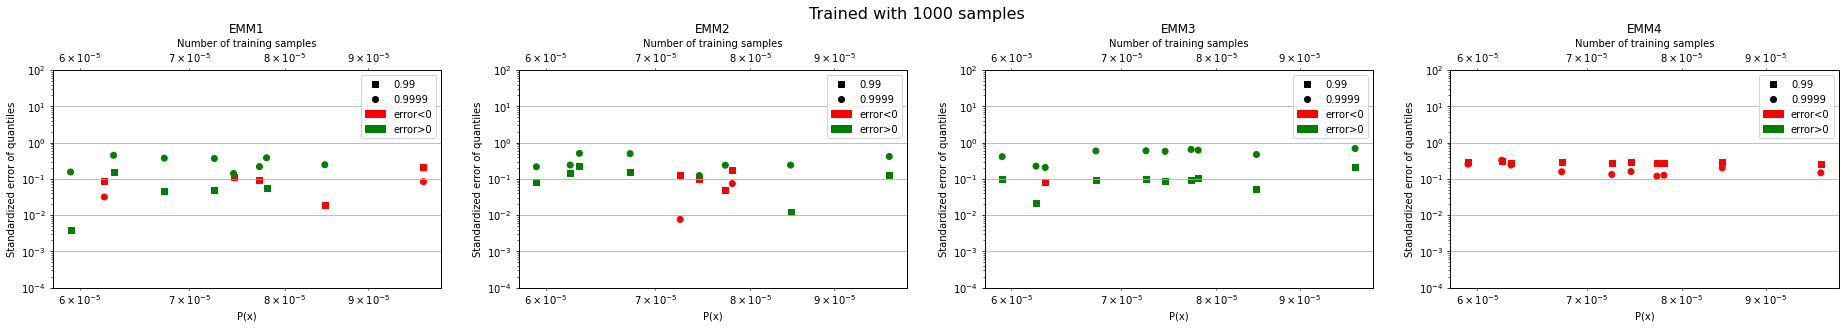

In [49]:
evaluate_models_allstates_plot(cma_results=eval_results,train_len=len(train_data),model_names=['EMM1','EMM2','EMM3','EMM4'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=True,ylim_ll=[1e-4,1e2])

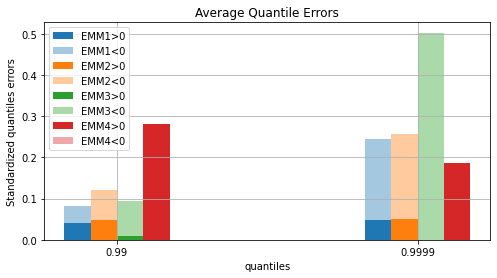

In [50]:
evaluate_models_allstates_agg(cma_results=eval_results,train_len=len(train_data),n_epoch=n_epoch,xsize=xsize,quantiles=quantiles,model_names=['EMM1','EMM2','EMM3','EMM4'])

In [75]:
eval_results_n = np.empty((0,20,xsize+(len(quantiles))+1))

In [74]:
#print(emm1_results_p)
#print(emm1_results)
emm1_results_n = np.append(emm1_results_p,emm1_results,axis=0)
emm2_results_n = np.append(emm2_results_p,emm2_results,axis=0)
emm3_results_n = np.append(emm3_results_p,emm3_results,axis=0)
emm4_results_n = np.append(emm4_results_p,emm4_results,axis=0)

In [71]:

eval_results_n = np.append(eval_results_n,[emm1_results_n],axis=0)
eval_results_n = np.append(eval_results_n,[emm2_results_n],axis=0)
eval_results_n = np.append(eval_results_n,[emm3_results_n],axis=0)
eval_results_n = np.append(eval_results_n,[emm4_results_n],axis=0)

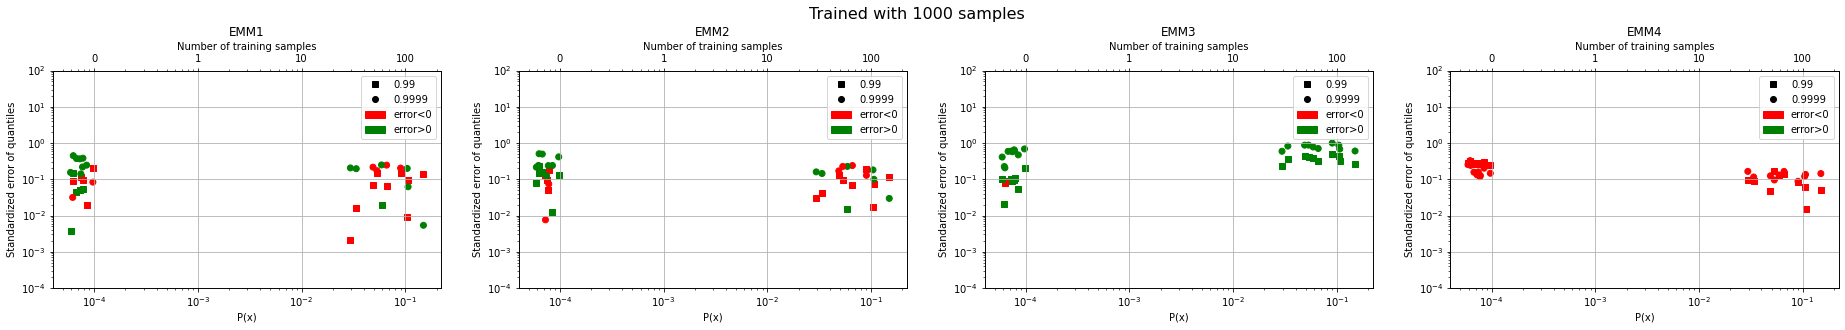

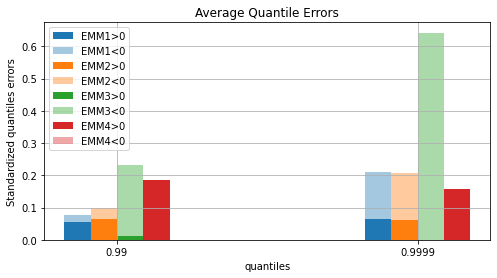

In [76]:
evaluate_models_allstates_plot(cma_results=eval_results_n,train_len=len(train_data),model_names=['EMM1','EMM2','EMM3','EMM4'],quantiles=quantiles,markers=['s','o','v','*','x'],loglog=True,ylim_ll=[1e-4,1e2])
evaluate_models_allstates_agg(cma_results=eval_results_n,train_len=len(train_data),n_epoch=n_epoch,xsize=xsize,quantiles=quantiles,model_names=['EMM1','EMM2','EMM3','EMM4'])